In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import curve_fit
import numpy as np
import matplotlib 
import pickle as pkl  
np.set_printoptions(suppress=True)
plt.rc('text', usetex=True)

dataDir = "../data/"
imageDir = "../images/"

In [2]:
# Load data
fluSeries = pd.read_pickle(dataDir + "pkls/fluSeries.pkl")
ausPop = pd.read_pickle(dataDir + "pkls/ausPop.pkl")

In [3]:
import os
if os.path.isfile(dataDir + "pkls/fluSIRParams.pkl"):
    fluParams = pkl.load(open(dataDir + "pkls/fluSIRParams.pkl", "rb"))
else:
    fluParams = {}

In [4]:
# Evaluation time
from datetime import datetime # Library for datetime format
from dateutil import relativedelta # Library to calculate delta time from date

year = 2017
startdate = str(year) + '-01'
enddate = str(year) + '-12'


date_format = "%Y-%m"
sd = datetime.strptime(startdate, date_format)
ed = datetime.strptime(enddate, date_format)

n_months = relativedelta.relativedelta(ed, sd) # Number of months (delta time)
print(n_months)

relativedelta(months=+11)


In [5]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 1
t_range = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - fluSeries[startdate])
I0 = (fluSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [6]:
# Defining SIR isolated equations
def SIR_eqs(SIR0,t, beta, gamma):
    S0=SIR0[0]
    I0=SIR0[1]
    R0=SIR0[2]

    S = - beta * S0 * I0/ausPop[year]
    I = (beta * S0 * I0/ausPop[year]) - gamma * I0
    R = gamma * I0

    return (S,I,R)

# Fitting function from infected data and I state on SIR model
def fitSIR(t, beta, gamma):
    return spi.odeint(SIR_eqs,SIR0,t_range,args=(beta,gamma))[:,1] 

def score(params):
    beta,gamma = params
    SIR_Res=fitSIR(t_range, beta, gamma)
    
    #c.Score Difference between model and data points
    def normMSE(data,model):
        data = np.array(data)
        model = np.array(model)
        n = len(data)
        mse = ((data-model)**2).sum()
        nmse = mse/(n*(data.sum()/n)*(model.sum()/n))
        
        return nmse
    return normMSE(fluSeries[startdate:enddate],SIR_Res)

In [7]:
from scipy.optimize import fmin

answ=fmin(score,(20, 20),full_output=1,maxiter=10000)
bestParams=answ[0]
bestscore=answ[1]
beta,gamma=answ[0]
paramsOpt=(beta,gamma)

print(paramsOpt,bestscore)

Optimization terminated successfully.
         Current function value: 0.805183
         Iterations: 56
         Function evaluations: 107
(8.993779282533158, 8.347865953418331) 0.8051828650381628


In [8]:
fluParams[year] = [beta, gamma, bestscore]
pkl.dump(fluParams, open(dataDir + 'pkls/fluSIRParams.pkl','wb'))

# Evaluation

In [9]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - fluSeries[startdate])
I0 = (fluSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [10]:
def fluSIRSim(beta,gamma):    
    return spi.odeint(SIR_eqs,SIR0,t_eval,args=(beta,gamma))

In [11]:
SIR = fluSIRSim(beta,gamma)
S = SIR[:,0]
I = SIR[:,1]
R = SIR[:,2]

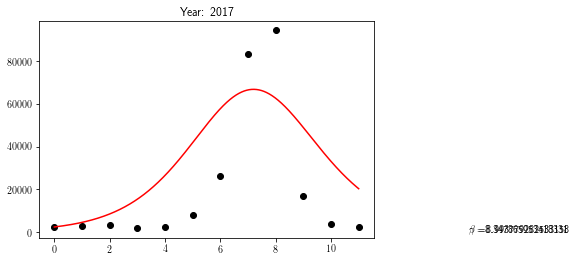

In [12]:
%matplotlib inline

plt.plot(t_range[:n_months.months+1], fluSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,I,'-r',label="Infected fit")
plt.text(15, 60, r'$\gamma = $' + str(gamma))
plt.text(15, 64, r'$\beta = $' + str(beta))
plt.title("Year: " + str(year))
plt.savefig(imageDir + "fluIsolated/flu_" + str(year) + ".png" )
plt.show()